# import needed libraries

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# creating dataframe for our data

In [2]:
data_dir = '/kaggle/input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    file_path = os.path.join(data_dir, fold)
    if not os.path.isdir(file_path):
        continue
    fpath = os.listdir(file_path)
    
    for f in fpath:
        fil_path=os.path.join(file_path,f)
        filepaths.append(fil_path)
        labels.append(fold)

f_series=pd.Series(filepaths,name='filepaths')
l_series=pd.Series(labels,name='labels')
df=pd.concat([f_series, l_series], axis= 1)

In [3]:
df

,filepaths,labels
0,/kaggle/input/pistachio-image-dataset/Pistachi...,Kirmizi_Pistachio
1,/kaggle/input/pistachio-image-dataset/Pistachi...,Kirmizi_Pistachio
2,/kaggle/input/pistachio-image-dataset/Pistachi...,Kirmizi_Pistachio
3,/kaggle/input/pistachio-image-dataset/Pistachi...,Kirmizi_Pistachio
4,/kaggle/input/pistachio-image-dataset/Pistachi...,Kirmizi_Pistachio
...,...,...
2143,/kaggle/input/pistachio-image-dataset/Pistachi...,Siirt_Pistachio
2144,/kaggle/input/pistachio-image-dataset/Pistachi...,Siirt_Pistachio
2145,/kaggle/input/pistachio-image-dataset/Pistachi...,Siirt_Pistachio
2146,/kaggle/input/pistachio-image-dataset/Pistachi...,Siirt_Pistachio


# splitting the data into train , test and validation

In [4]:
# train dataframe  80% train  20% dummy
train_df, dummy_df = train_test_split(df,  test_size= 0.2, shuffle= True, random_state= 43)

# valid and test dataframe 10% validate  10% test
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 43)

# create image generator

In [5]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 1718 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.


# First Tuned Pre-Trained model: EfficientNetB3


In [6]:
# Define input image dimensions
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Define number of classes

# Define the input layer
inputs = tf.keras.Input(shape=img_shape)

# Load the pre-trained EfficientNetB3 model without the top layer
base_model = keras.applications.EfficientNetB3(include_top=False, weights="imagenet", 
input_tensor=inputs)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling to match the target shape
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# training model

In [7]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model with frozen layers
history1 = model.fit(train_gen, epochs=15, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/15


I0000 00:00:1731521663.414394     136 service.cc:145] XLA service 0x7ec4080023d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731521663.414460     136 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731521663.414466     136 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/108 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.5000 - loss: 20.0006    

I0000 00:00:1731521702.110076     136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 ━━━━━━━━━━━━━━━━━━━━ 122s 617ms/step - accuracy: 0.7189 - loss: 15.3317 - val_accuracy: 0.7814 - val_loss: 6.2088
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8481 - loss: 7.1857 - val_accuracy: 0.5535 - val_loss: 5.1753
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8166 - loss: 5.1129 - val_accuracy: 0.5721 - val_loss: 4.3538
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.7995 - loss: 4.2063 - val_accuracy: 0.5860 - val_loss: 3.6343
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.7699 - loss: 3.4759 - val_accuracy: 0.6512 - val_loss: 3.0070
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.7665 - loss: 2.8714 - val_accuracy: 0.8093 - val_loss: 2.4666
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.7407 - loss: 2.3636 - val_accuracy: 0.7674 - val_loss: 2.0320
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.7725 - loss: 1.9359 - val_accuracy: 0

# first model performance

In [8]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

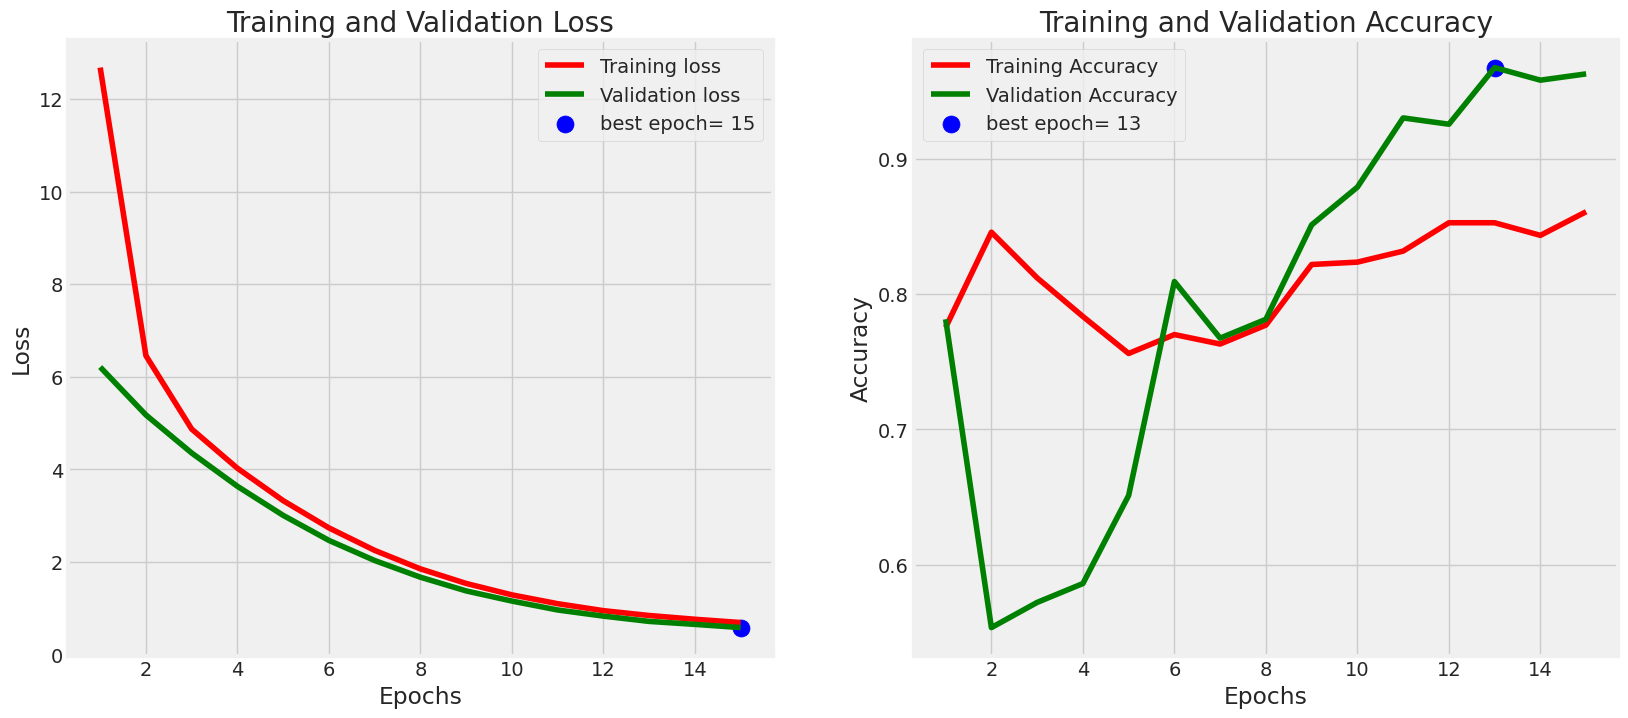

In [9]:
plot_training(history1)


# Second Tuned Pre-Trained model:ResNet50

In [13]:
# Define input image dimensions
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Define number of classes

# Define the input layer
inputs = tf.keras.Input(shape=img_shape)

# Load the pre-trained EfficientNetB3 model without the top layer
base_model = keras.applications.ResNet50(include_top=False, weights="imagenet", 
input_tensor=inputs)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling to match the target shape
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



# training model

In [14]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]
history2 = model.fit(train_gen, epochs=15, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 32s 164ms/step - accuracy: 0.7916 - loss: 14.7757 - val_accuracy: 0.8977 - val_loss: 6.6713
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8822 - loss: 6.5418 - val_accuracy: 0.6884 - val_loss: 5.1843
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.8804 - loss: 4.9928 - val_accuracy: 0.6372 - val_loss: 4.2747
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8303 - loss: 4.0760 - val_accuracy: 0.7256 - val_loss: 3.5119
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8368 - loss: 3.3237 - val_accuracy: 0.7907 - val_loss: 2.8754
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.8515 - loss: 2.7027 - val_accuracy: 0.8186 - val_loss: 2.3450
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.8414 - loss: 2.1928 - val_accuracy: 0.8744 - val_loss: 1.9039
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.8463 - loss: 1.7947 - val_a

# second model performance

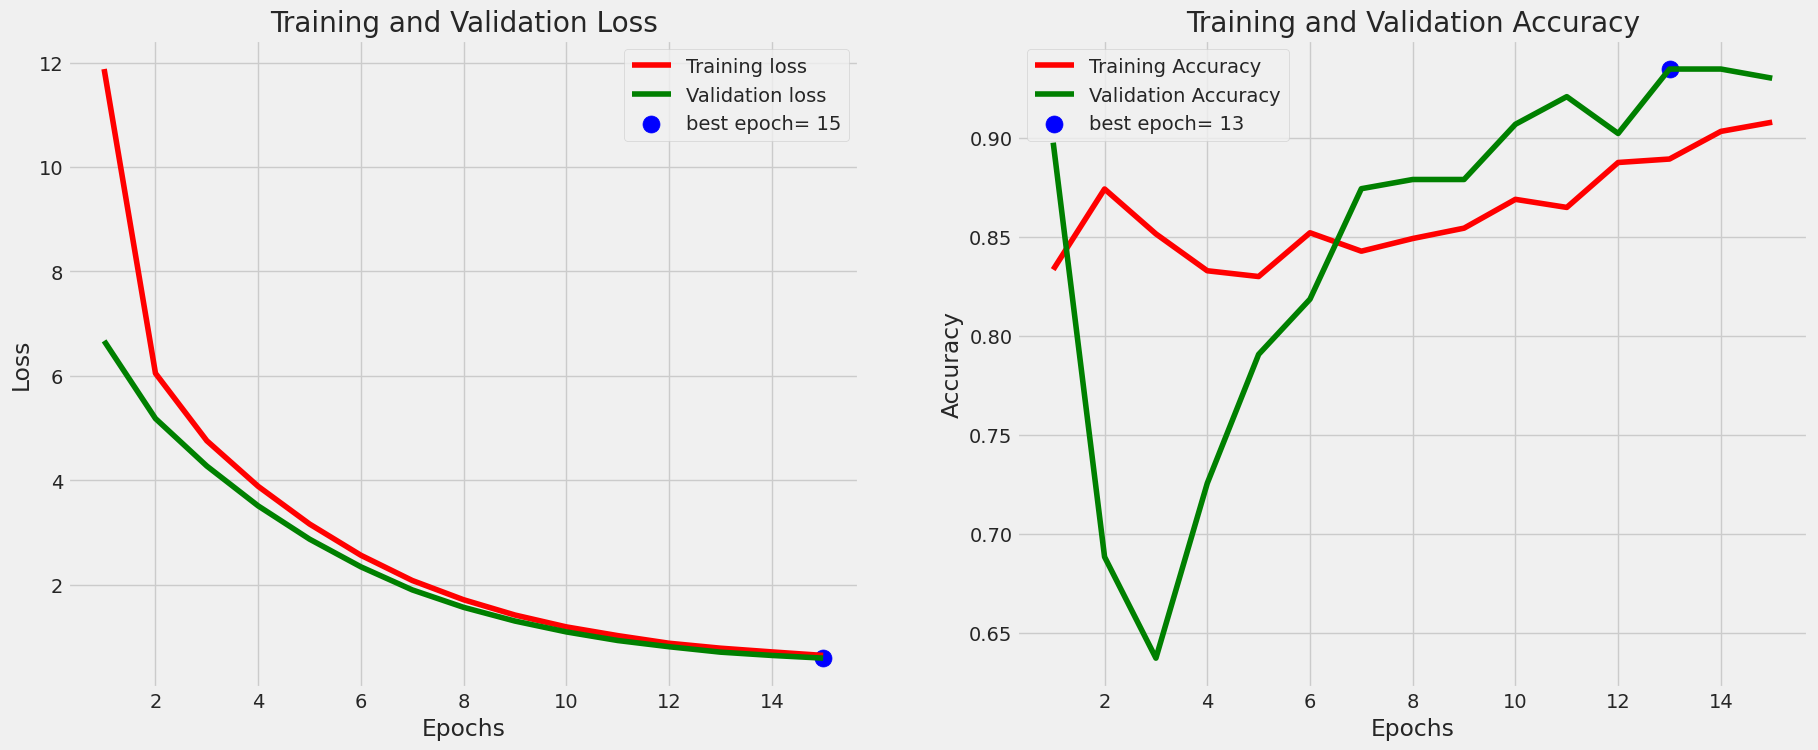

In [15]:
plot_training(history2)

# Third Tuned Pre-Trained model: VGG16

In [16]:
# Define input image dimensions
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))  # Define number of classes

# Define the input layer
inputs = tf.keras.Input(shape=img_shape)

# Load the pre-trained InceptionV3 model without the top layer
base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# training model

In [17]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]
history3 = model.fit(train_gen, epochs=15, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.7826 - loss: 13.8192 - val_accuracy: 0.8977 - val_loss: 8.8850
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.8825 - loss: 6.9632 - val_accuracy: 0.8744 - val_loss: 4.4029
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.8838 - loss: 4.0929 - val_accuracy: 0.8000 - val_loss: 3.4850
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.8506 - loss: 3.2294 - val_accuracy: 0.8093 - val_loss: 2.9407
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.8128 - loss: 2.6809 - val_accuracy: 0.7767 - val_loss: 2.4986
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.7982 - loss: 2.2537 - val_accuracy: 0.7953 - val_loss: 2.1180
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.8352 - loss: 1.8834 - val_accuracy: 0.8884 - val_loss: 1.7665
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.8623 - loss: 1.5719 - val_a

# third model performance

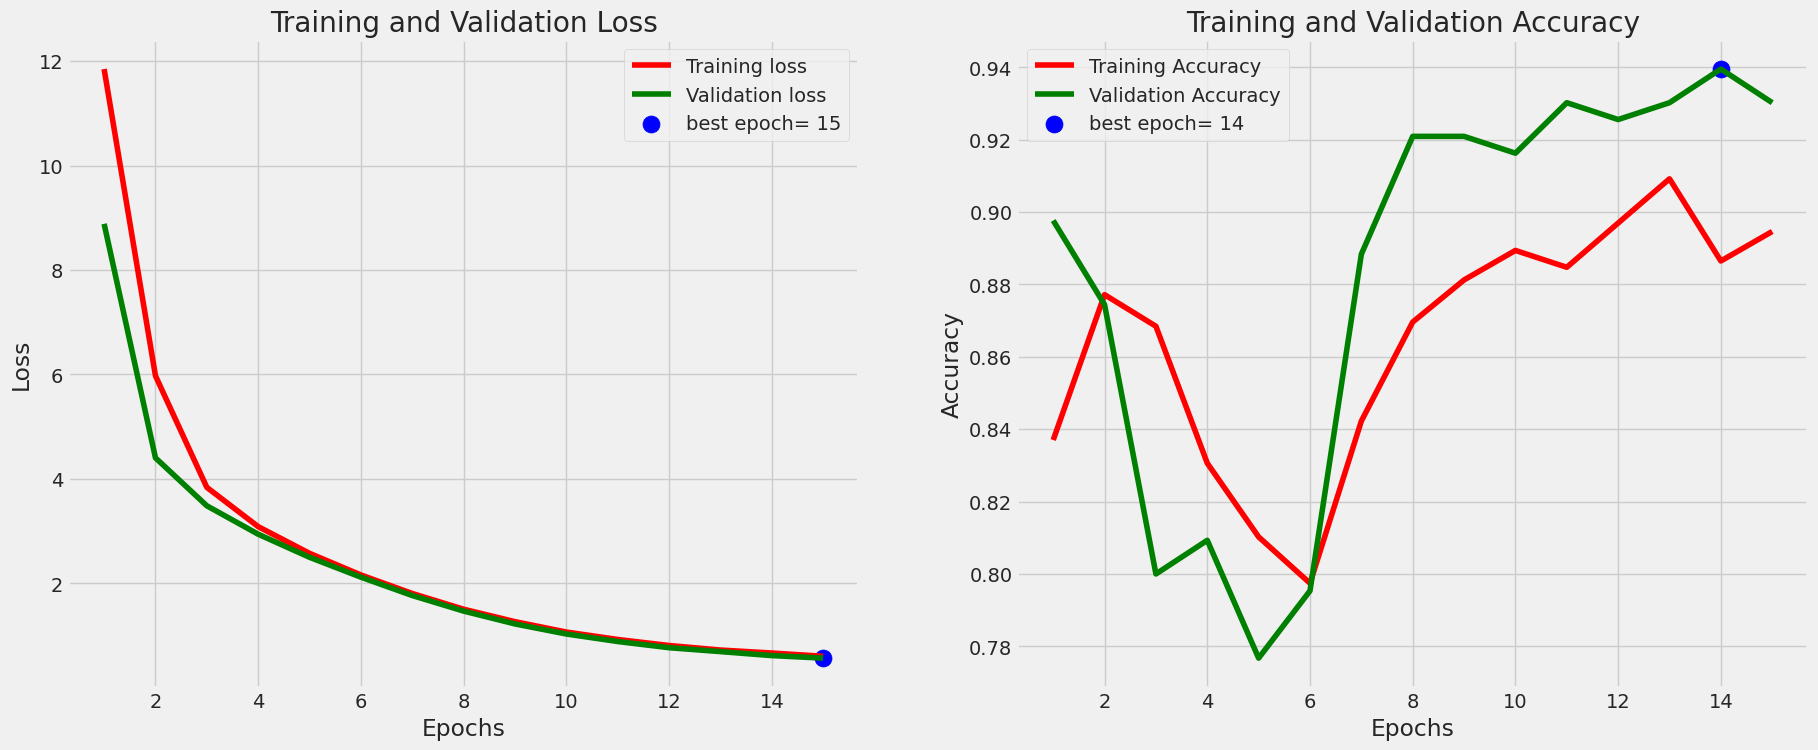

In [18]:
plot_training(history3)

# Comparison Between the 3 Models

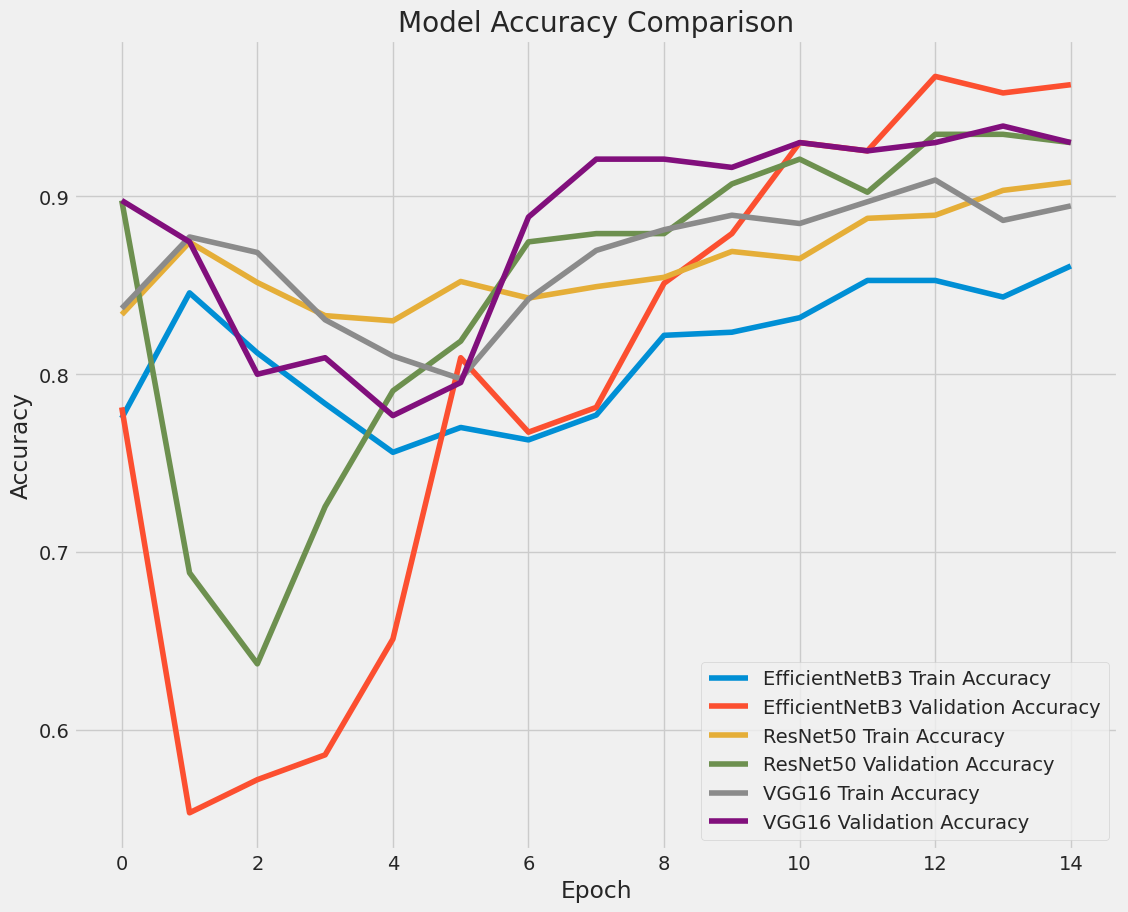

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 10))

# EfficientNetB3
plt.plot(history1.history['accuracy'], label='EfficientNetB3 Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='EfficientNetB3 Validation Accuracy')

# ResNet50
plt.plot(history2.history['accuracy'], label='ResNet50 Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='ResNet50 Validation Accuracy')

# VGG16
plt.plot(history3.history['accuracy'], label='VGG16 Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='VGG16 Validation Accuracy')

plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()